# Segmentation Analysis

Objective: Gain insights of the customer segments that merit heightened marketing investment

Metadata:
* age - age of the applicant
* car_type - the type of car the loan application was for, one Convertible, Saloon and SUV
* loan_amount - loan amount applied for
* area - based on the postcode of the applicant, to determine whether they live in an urban or rural area
* apr - annual percentage rate - refers to the total cost of your borrowing for a year
* application_outcome - whether the loan was approved or declined
* funded - whether the application approval converted into a funded loan

**Outcome:**
<p>The best segment to invest in is middle age customers living in the urban area. This segment has the highest acceptance rate 73% and more than 50% get a conversion to a funded loan.</p>

In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import silhouette_visualizer

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

import copy

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Improve quality of graphs

In [2]:
dataset = pd.read_excel('raw_data.xlsx')

### Data Cleaning

In [3]:
dataset = copy.deepcopy(dataset)

In [4]:
dataset.head()

ID  age     car_type  Loanamount    Deposit    area   APR  \
0  9997   61  Convertible   £24,108.00    £881.00  rural  0.15   
1  9996   42       Saloon    £5,988.00    £967.00  rural  0.20   
2  9995   57       Saloon    £5,099.00    £973.00  urban  0.15   
3  9994   32  Convertible   £20,774.00  £1,478.00  rural   NaN   
4  9993   29       Saloon    £4,612.00    £774.00  urban   NaN   

  application_outcome Funded   
0            approved      No  
1            approved      No  
2            approved      No  
3            declined     NaN  
4            declined     NaN

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   car_type             10000 non-null  object 
 3    Loanamount          10000 non-null  object 
 4    Deposit             10000 non-null  object 
 5   area                 10000 non-null  object 
 6   APR                  6457 non-null   float64
 7   application_outcome  10000 non-null  object 
 8   Funded               6470 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 703.2+ KB


In [6]:
# Correct column names to an appropriate format
column_names =  list(dataset.columns.str.strip().str.lower())
index = column_names.index('loanamount')
column_names[index] = 'loan_amount'

In [7]:
dataset.set_axis(column_names, axis=1, inplace=True)

In [8]:
# Duplicate check
dataset.duplicated().sum()

0

In [9]:
# Verify the uniqueness of elements to set an index
dataset.shape[0] == dataset['id'].nunique()

True

In [10]:
# Set index
dataset.set_index('id', inplace=True)

In [11]:
# Check for missing data
dataset.isnull().sum()

age                       0
car_type                  0
loan_amount               0
deposit                   0
area                      0
apr                    3543
application_outcome       0
funded                 3530
dtype: int64

In [12]:
dataset.head()

age     car_type loan_amount    deposit   area   apr  \
id                                                           
9997   61  Convertible  £24,108.00    £881.00  rural  0.15   
9996   42       Saloon   £5,988.00    £967.00  rural  0.20   
9995   57       Saloon   £5,099.00    £973.00  urban  0.15   
9994   32  Convertible  £20,774.00  £1,478.00  rural   NaN   
9993   29       Saloon   £4,612.00    £774.00  urban   NaN   

     application_outcome funded  
id                               
9997            approved     No  
9996            approved     No  
9995            approved     No  
9994            declined    NaN  
9993            declined    NaN

In [13]:
# Correct column values to an appropriate format
for i in dataset[['loan_amount', 'deposit']].columns:
    dataset[i] = dataset[i].apply(lambda x: x.replace('£', ''))
    dataset[i] = dataset[i].apply(lambda x: x.replace(',', ''))

In [14]:
# Correct data type
dataset[['loan_amount', 'deposit']] = dataset[['loan_amount', 'deposit']].astype('float')

In [15]:
dataset.head()

age     car_type  loan_amount  deposit   area   apr application_outcome  \
id                                                                              
9997   61  Convertible      24108.0    881.0  rural  0.15            approved   
9996   42       Saloon       5988.0    967.0  rural  0.20            approved   
9995   57       Saloon       5099.0    973.0  urban  0.15            approved   
9994   32  Convertible      20774.0   1478.0  rural   NaN            declined   
9993   29       Saloon       4612.0    774.0  urban   NaN            declined   

     funded  
id           
9997     No  
9996     No  
9995     No  
9994    NaN  
9993    NaN

In [16]:
# Adjust categorical values
for i in dataset.select_dtypes('object').columns:
    dataset[i] = dataset[i].str.strip().str.capitalize()
dataset['car_type'] = dataset['car_type'].str.replace('Suv', 'SUV')

In [17]:
dataset

age     car_type  loan_amount  deposit   area   apr application_outcome  \
id                                                                              
9997   61  Convertible      24108.0    881.0  Rural  0.15            Approved   
9996   42       Saloon       5988.0    967.0  Rural  0.20            Approved   
9995   57       Saloon       5099.0    973.0  Urban  0.15            Approved   
9994   32  Convertible      20774.0   1478.0  Rural   NaN            Declined   
9993   29       Saloon       4612.0    774.0  Urban   NaN            Declined   
...   ...          ...          ...      ...    ...   ...                 ...   
8876   38  Convertible      23904.0   5998.0  Urban  0.05            Approved   
8179   19       Saloon       8559.0   5999.0  Rural   NaN            Declined   
9535   52  Convertible      19296.0   5999.0  Rural  0.05            Approved   
8989   35          SUV      12234.0   6000.0  Urban  0.05            Approved   
9613   55       Saloon       7475.0   6000.0  Urban  0.15            Approved   

     funded  
id           
9997     No  
9996     No  
9995     No  
9994    NaN  
9993    NaN  
...     ...  
8876     No  
8179    NaN  
9535     No  
8989    Yes  
9613    Yes  

[10000 rows x 8 columns]

In [18]:
# Missing values in %
dataset.isnull().mean()*100

age                     0.00
car_type                0.00
loan_amount             0.00
deposit                 0.00
area                    0.00
apr                    35.43
application_outcome     0.00
funded                 35.30
dtype: float64

In [19]:
dataset.isnull().sum()

age                       0
car_type                  0
loan_amount               0
deposit                   0
area                      0
apr                    3543
application_outcome       0
funded                 3530
dtype: int64

In [20]:
# Let's understand which data is missing in APR Funded columns and if they are random
data_null = dataset[dataset['apr'].isnull()]
data_null.head()


# When the application is declined I observe missing values in APR and Funded columns
# Those that are Approved, are missing at random?
# seems to be.

# In APRthose with a Declined outcome I will fill using 0.00 and 
# Those missing at random I will fill with mean by the car type

age     car_type  loan_amount  deposit   area  apr application_outcome  \
id                                                                             
9994   32  Convertible      20774.0   1478.0  Rural  NaN            Declined   
9993   29       Saloon       4612.0    774.0  Urban  NaN            Declined   
9988   63       Saloon       2980.0    679.0  Rural  NaN            Declined   
9979   21  Convertible      18056.0   1152.0  Urban  NaN            Declined   
9978   19          SUV      14884.0   1233.0  Rural  NaN            Declined   

     funded  
id           
9994    NaN  
9993    NaN  
9988    NaN  
9979    NaN  
9978    NaN

In [21]:
data_null[data_null['application_outcome']=='Approved']

age     car_type  loan_amount  deposit   area  apr application_outcome  \
id                                                                             
9831   37       Saloon       5339.0    971.0  Rural  NaN            Approved   
8670   54       Saloon       5320.0    779.0  Urban  NaN            Approved   
8131   52  Convertible      22729.0    849.0  Urban  NaN            Approved   
8130   36  Convertible      24516.0   1426.0  Rural  NaN            Approved   
7225   37  Convertible      10292.0   1328.0  Urban  NaN            Approved   
7145   48  Convertible      26019.0   1419.0  Urban  NaN            Approved   
7099   40  Convertible      20665.0   1673.0  Urban  NaN            Approved   
6377   22  Convertible      22973.0   1417.0  Urban  NaN            Approved   
6056   60  Convertible      22930.0   1142.0  Rural  NaN            Approved   
5641   43  Convertible      10373.0   1164.0  Urban  NaN            Approved   
1072   42          SUV      10779.0   4236.0  Urban  NaN            Approved   
385    47       Saloon       8595.0   4238.0  Urban  NaN            Approved   
6352   58          SUV      16920.0   4447.0  Rural  NaN            Approved   

     funded  
id           
9831    Yes  
8670    Yes  
8131    Yes  
8130    Yes  
7225     No  
7145     No  
7099     No  
6377     No  
6056     No  
5641     No  
1072     No  
385     Yes  
6352     No

In [22]:
data_null[data_null['application_outcome']=='Approved'].shape

(13, 8)

In [23]:
dataset.loc[(dataset['application_outcome']=='Declined') & (dataset['apr'].isnull()), :].shape

(3530, 8)

In [24]:
apr_mean_by_car_type = dataset.groupby('car_type').mean()['apr']
apr_mean_by_car_type

car_type
Convertible    0.117662
SUV            0.150877
Saloon         0.177589
Name: apr, dtype: float64

In [25]:
def fill_the_mean(condition_col, target_col, value_to_be_inserted, df):
    
    new_target_var = []
    
    for x, y in zip(condition_col, target_col):
        if str(y).lower()=='nan' or  str(y).lower()=='none':
            y = round(value_to_be_inserted[x], 2) # take corresponding mean value
        new_target_var.append(y)
    new_target_var = pd.Series(new_target_var)
    df['apr'] = new_target_var        
    return df.head()

In [26]:
fill_the_mean(dataset['car_type'], dataset['apr'], apr_mean_by_car_type, dataset)

age     car_type  loan_amount  deposit   area   apr application_outcome  \
id                                                                              
9997   61  Convertible      24108.0    881.0  Rural  0.05            Approved   
9996   42       Saloon       5988.0    967.0  Rural  0.18            Approved   
9995   57       Saloon       5099.0    973.0  Urban  0.05            Approved   
9994   32  Convertible      20774.0   1478.0  Rural  0.20            Declined   
9993   29       Saloon       4612.0    774.0  Urban  0.12            Declined   

     funded  
id           
9997     No  
9996     No  
9995     No  
9994    NaN  
9993    NaN

In [27]:
# Check if filled
dataset.isnull().sum()
# There is one missing, let's investigate

age                       0
car_type                  0
loan_amount               0
deposit                   0
area                      0
apr                       1
application_outcome       0
funded                 3530
dtype: int64

In [28]:
dataset[dataset['apr'].isnull()]

age car_type  loan_amount  deposit   area  apr application_outcome  \
id                                                                          
10000   18   Saloon      11911.0   3416.0  Rural  NaN            Approved   

      funded  
id            
10000     No

In [29]:
# We see that in all aproved application there is no missing data in funded column
dataset[(dataset['application_outcome'] == 'Approved') & (dataset['funded'].isnull())]

Empty DataFrame
Columns: [age, car_type, loan_amount, deposit, area, apr, application_outcome, funded]
Index: []

In [30]:
# All the missing values are missing in funded column because the application was Declined
# This is why I am going to fill nan with a No value
dataset[(dataset['application_outcome'] == 'Declined') & (dataset['funded'].isnull())]

age     car_type  loan_amount  deposit   area   apr application_outcome  \
id                                                                              
9994   32  Convertible      20774.0   1478.0  Rural  0.20            Declined   
9993   29       Saloon       4612.0    774.0  Urban  0.12            Declined   
9988   63       Saloon       2980.0    679.0  Rural  0.10            Declined   
9979   21  Convertible      18056.0   1152.0  Urban  0.18            Declined   
9978   19          SUV      14884.0   1233.0  Rural  0.15            Declined   
...   ...          ...          ...      ...    ...   ...                 ...   
9304   64  Convertible      21808.0   5996.0  Rural  0.05            Declined   
5770   29       Saloon       7015.0   5997.0  Rural  0.18            Declined   
1448   35  Convertible      19453.0   5997.0  Rural  0.15            Declined   
4080   62  Convertible      25622.0   5997.0  Rural  0.25            Declined   
8179   19       Saloon       8559.0   5999.0  Rural  0.18            Declined   

     funded  
id           
9994    NaN  
9993    NaN  
9988    NaN  
9979    NaN  
9978    NaN  
...     ...  
9304    NaN  
5770    NaN  
1448    NaN  
4080    NaN  
8179    NaN  

[3530 rows x 8 columns]

In [31]:
dataset['funded'].fillna('No', inplace=True)

In [32]:
dataset.isnull().sum()

age                    0
car_type               0
loan_amount            0
deposit                0
area                   0
apr                    1
application_outcome    0
funded                 0
dtype: int64

In [33]:
# Delete the row that is not filled
dataset.dropna(inplace=True)

In [34]:
dataset.isnull().sum()

age                    0
car_type               0
loan_amount            0
deposit                0
area                   0
apr                    0
application_outcome    0
funded                 0
dtype: int64

In [35]:
# Now lets verify basic statistics

In [36]:
round(dataset.describe(), 3)

age  loan_amount   deposit       apr
count  9999.000     9999.000  9999.000  9999.000
mean     40.480    11920.431  2668.067     0.150
std      14.015     5883.119  1669.251     0.053
min      18.000     2502.000   500.000     0.050
25%      27.000     7526.500  1106.000     0.120
50%      40.000    11218.000  2364.000     0.150
75%      53.000    15924.500  4079.500     0.180
max      65.000    26986.000  6000.000     0.250

In [37]:
# Le's see the distribution
dataset.quantile(np.arange(0.00, 1.1, 0.10))

age  loan_amount  deposit   apr
0.0  18.0       2502.0    500.0  0.05
0.1  23.0       4337.6    812.0  0.05
0.2  25.0       6257.4    938.0  0.10
0.3  30.0       8624.0   1267.0  0.12
0.4  35.0       9434.2   1681.0  0.15
0.5  40.0      11218.0   2364.0  0.15
0.6  45.0      13053.8   3027.0  0.15
0.7  50.0      14903.0   3745.2  0.18
0.8  55.0      17269.4   4461.4  0.20
0.9  61.0      20215.0   5206.2  0.20
1.0  65.0      26986.0   6000.0  0.25

In [38]:
dataset.select_dtypes(('int', 'float')).skew()

age            0.127702
loan_amount    0.415439
deposit        0.421559
apr           -0.047295
dtype: float64

In [39]:
dataset.select_dtypes(('int', 'float')).kurtosis()

age           -1.258750
loan_amount   -0.628247
deposit       -1.171464
apr           -0.236243
dtype: float64

In [40]:
dataset.corr()
# Data seems to be not correlated

age  loan_amount   deposit       apr
age          1.000000     0.065728  0.090886 -0.006298
loan_amount  0.065728     1.000000  0.270475 -0.002955
deposit      0.090886     0.270475  1.000000 -0.014440
apr         -0.006298    -0.002955 -0.014440  1.000000

In [41]:
# Verify inconsistencies
dataset[dataset['loan_amount'] < dataset['deposit']]

Empty DataFrame
Columns: [age, car_type, loan_amount, deposit, area, apr, application_outcome, funded]
Index: []

In [42]:
dataset[(dataset['application_outcome'] == 'Declined') & (dataset['funded'] == 'Yes')]

Empty DataFrame
Columns: [age, car_type, loan_amount, deposit, area, apr, application_outcome, funded]
Index: []

In [43]:
# Check outliers in the loan amount, deposit, and age columns

{'whiskers': [<matplotlib.lines.Line2D at 0x7fae054e3d60>,
 'caps': [<matplotlib.lines.Line2D at 0x7fae0a1ec400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fae054e3910>],
 'medians': [<matplotlib.lines.Line2D at 0x7fae0a1ecb20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fae0a1eceb0>],
 'means': []}

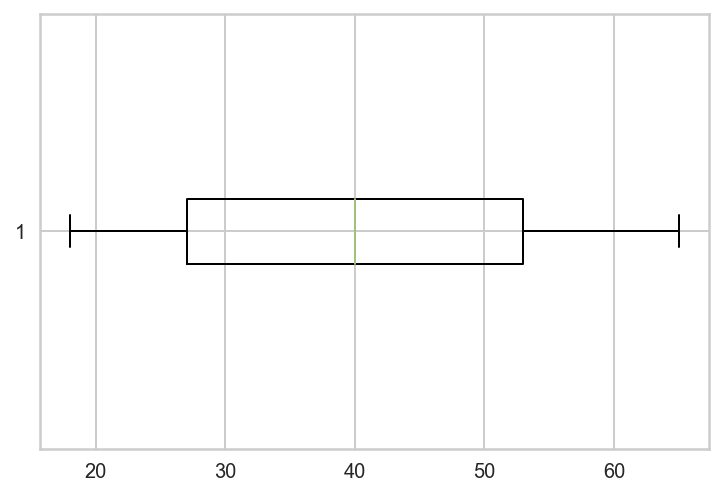

In [44]:
plt.boxplot(dataset['age'], vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fae0a7494c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fae0a749be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fae0a749130>],
 'medians': [<matplotlib.lines.Line2D at 0x7fae0a755340>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fae0a7556d0>],
 'means': []}

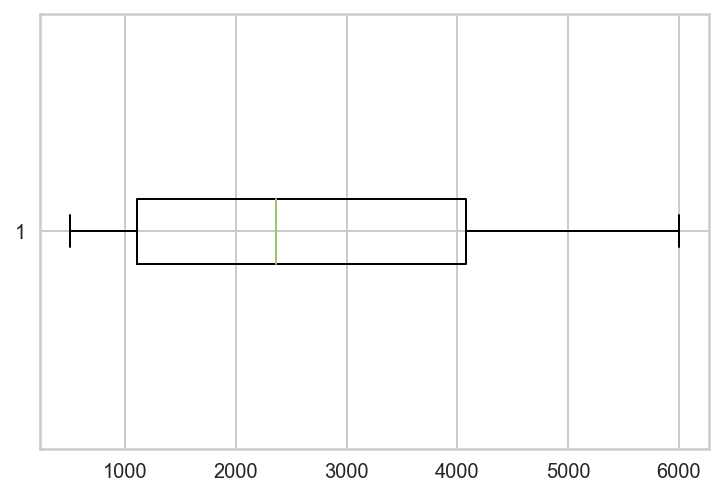

In [45]:
plt.boxplot(dataset['deposit'], vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fae0a915610>,
 'caps': [<matplotlib.lines.Line2D at 0x7fae0a915d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fae0a915280>],
 'medians': [<matplotlib.lines.Line2D at 0x7fae0a921490>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fae0a921820>],
 'means': []}

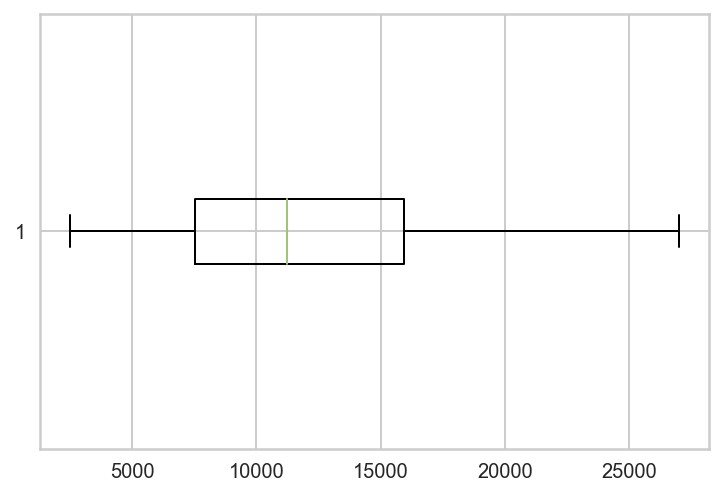

In [46]:
plt.boxplot(dataset['loan_amount'], vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fae0aae10d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fae0aae17f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fae0a972d00>],
 'medians': [<matplotlib.lines.Line2D at 0x7fae0aae1f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fae0aaeb2e0>],
 'means': []}

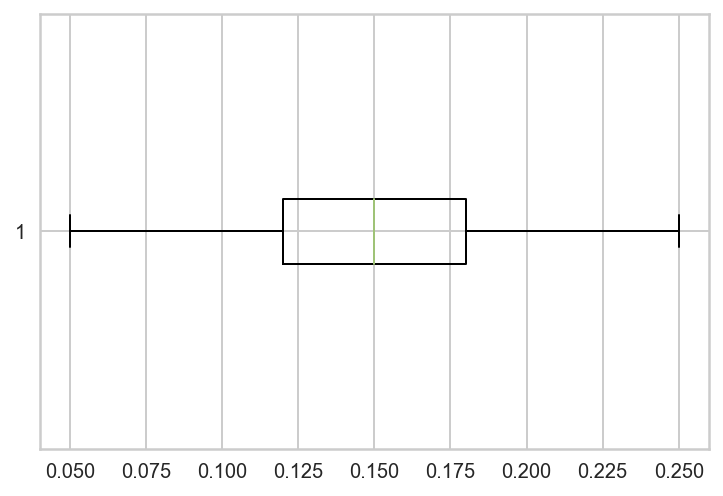

In [47]:
plt.boxplot(dataset['apr'], vert=False)

In [48]:
# No outliers
# Date are ready for analysis
clean_data = copy.deepcopy(dataset)

### Exploratory Data Analysis

In [49]:
dataset = copy.deepcopy(clean_data)
dataset.head()

age     car_type  loan_amount  deposit   area   apr application_outcome  \
id                                                                              
9997   61  Convertible      24108.0    881.0  Rural  0.05            Approved   
9996   42       Saloon       5988.0    967.0  Rural  0.18            Approved   
9995   57       Saloon       5099.0    973.0  Urban  0.05            Approved   
9994   32  Convertible      20774.0   1478.0  Rural  0.20            Declined   
9993   29       Saloon       4612.0    774.0  Urban  0.12            Declined   

     funded  
id           
9997     No  
9996     No  
9995     No  
9994     No  
9993     No

In [50]:
dataset.select_dtypes(include=('float', 'int')).describe()

age   loan_amount      deposit          apr
count  9999.000000   9999.000000  9999.000000  9999.000000
mean     40.479648  11920.431143  2668.067307     0.149502
std      14.014801   5883.119475  1669.250745     0.053201
min      18.000000   2502.000000   500.000000     0.050000
25%      27.000000   7526.500000  1106.000000     0.120000
50%      40.000000  11218.000000  2364.000000     0.150000
75%      53.000000  15924.500000  4079.500000     0.180000
max      65.000000  26986.000000  6000.000000     0.250000

In [51]:
application_by_area =pd.crosstab(dataset['area'], dataset['application_outcome'])

application_by_area['Totals'] = dataset['area'].value_counts()
application_by_area['Approved (%)'] = round((application_by_area['Approved']/application_by_area['Totals'])*100)
application_by_area['Declined (%)'] = round((application_by_area['Declined']/application_by_area['Totals'])*100)
application_by_area

application_outcome  Approved  Declined  Totals  Approved (%)  Declined (%)
area                                                                       
Rural                    3042      2247    5289          58.0          42.0
Urban                    3427      1283    4710          73.0          27.0

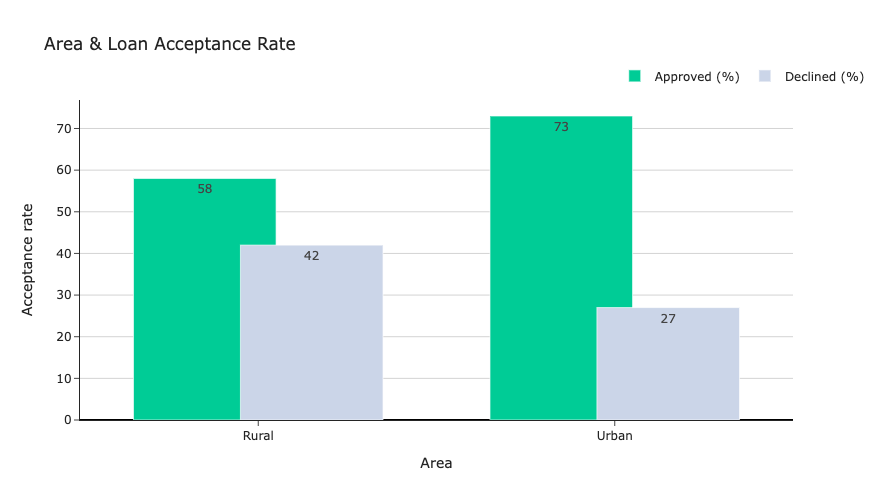

In [52]:
#Visualisation
fig = px.bar(
    application_by_area,
    x=application_by_area.index,
    y=['Approved (%)', 'Declined (%)'], 
    title='Area & Loan Acceptance Rate',
    width=800, 
    height=500, 
    text_auto=True, 
    color_discrete_map={# replaces default color mapping by value
    'Declined (%)': 'rgb(203, 213, 232)', 'Approved (%)': '#00CC96'},
    labels={# replaces default labels by column name
        'value': 'Acceptance rate', 'area': 'Area'},
    template='simple_white'
)

fig.update_layout(
    legend=dict(orientation='h', yanchor='bottom', y=1.03, x=0.75), 
    legend_title_text=None
)
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_traces(width=0.4)
fig.update_layout(barmode='group', bargap=0.40, bargroupgap=0.3)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Lightgrey')

fig.show()

In [53]:
acceptance_by_car = pd.crosstab(dataset['application_outcome'], dataset['car_type'])
acceptance_by_car['Tolals'] = dataset['application_outcome'].value_counts()

In [54]:
fig_data = copy.deepcopy(clean_data)

fig_data['funded'] = np.where(fig_data['funded'] == 'Yes', 'Funded', 'Not Funded')
fig_data['car_type'] = fig_data['car_type'].str.replace('Suv', 'SUV')

In [85]:
fig_data

age     car_type  loan_amount  deposit   area   apr application_outcome  \
id                                                                              
9997   61  Convertible      24108.0    881.0  Rural  0.05            Approved   
9996   42       Saloon       5988.0    967.0  Rural  0.18            Approved   
9995   57       Saloon       5099.0    973.0  Urban  0.05            Approved   
9994   32  Convertible      20774.0   1478.0  Rural  0.20            Declined   
9993   29       Saloon       4612.0    774.0  Urban  0.12            Declined   
...   ...          ...          ...      ...    ...   ...                 ...   
8876   38  Convertible      23904.0   5998.0  Urban  0.15            Approved   
8179   19       Saloon       8559.0   5999.0  Rural  0.18            Declined   
9535   52  Convertible      19296.0   5999.0  Rural  0.10            Approved   
8989   35          SUV      12234.0   6000.0  Urban  0.10            Approved   
9613   55       Saloon       7475.0   6000.0  Urban  0.20            Approved   

          funded  
id                
9997  Not Funded  
9996  Not Funded  
9995  Not Funded  
9994  Not Funded  
9993  Not Funded  
...          ...  
8876  Not Funded  
8179  Not Funded  
9535  Not Funded  
8989      Funded  
9613      Funded  

[9999 rows x 8 columns]

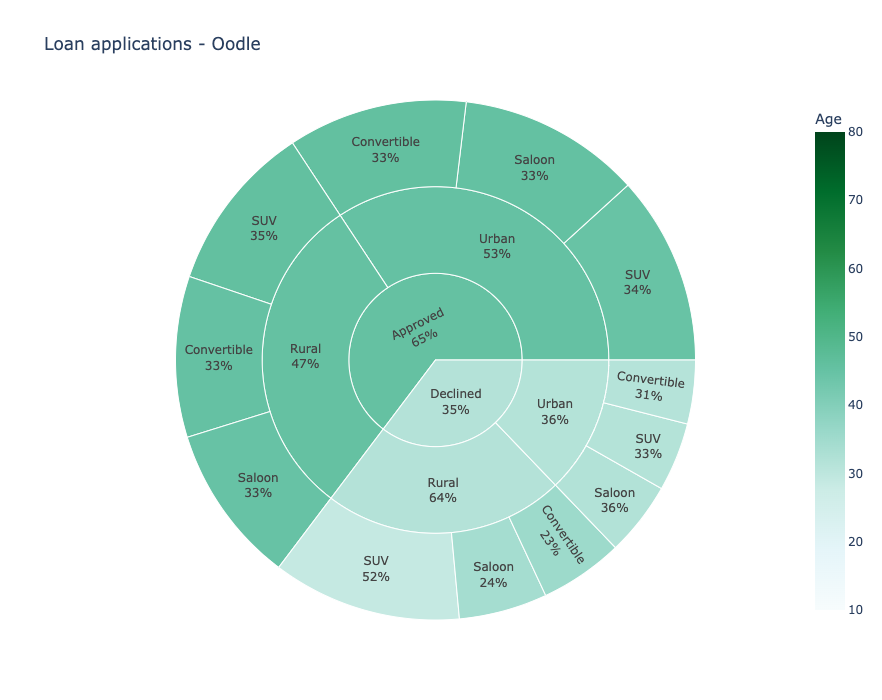

In [55]:
fig = px.sunburst(
    data_frame=fig_data, 
    path=['application_outcome', 'area', 'car_type', 'funded'],
    #color='application_outcome',
    #color_discrete_sequence=px.colors.qualitative.Pastel2,
    title='Loan applications - Oodle',
    maxdepth=3, # if -1, will render all levels in the hierarchy, otherwise put a number
    color = 'age',
    color_continuous_scale=px.colors.sequential.BuGn,
    range_color=[10, 80],
    #hover_data={'parent': False},
    #branchvalues='remainder',
    height=700)

fig.update_traces(textinfo='label+percent parent')
#fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.layout.coloraxis.colorbar.title='Age'
fig.show()

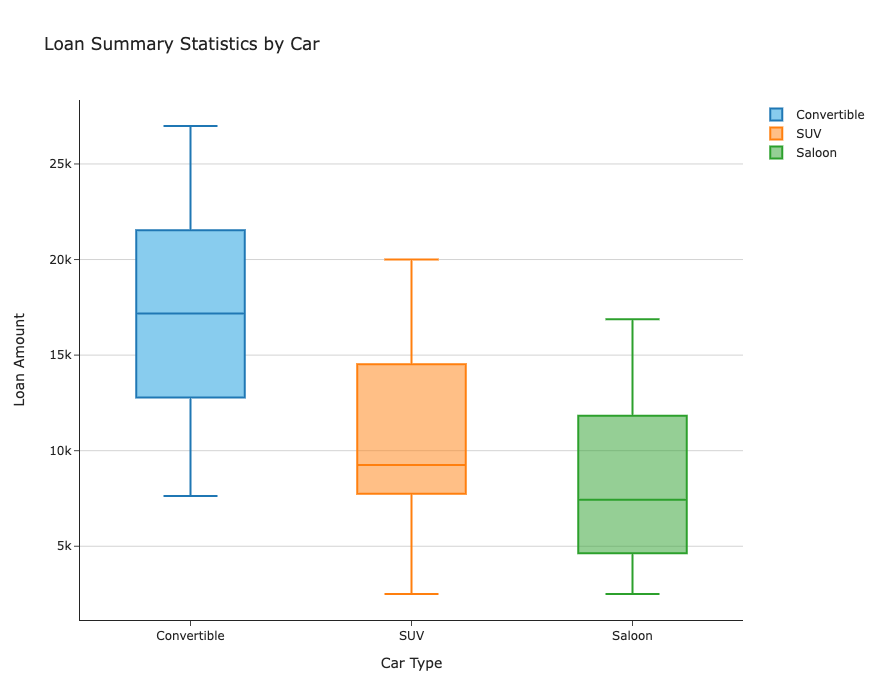

In [56]:
fig = go.Figure()

fig.add_trace(
    go.Box(
        name='Convertible', 
        y=dataset[dataset['car_type'] == 'Convertible']['loan_amount'], 
        fillcolor='rgb(136, 204, 238)'
    )
)

fig.add_trace(
    go.Box(
        name='SUV', 
        y=dataset[dataset['car_type'] == 'SUV']['loan_amount'],
    )
)

fig.add_trace(
    go.Box(
        name = 'Saloon', 
        y=dataset[dataset['car_type']=='Saloon']['loan_amount']
    )
)

fig.update_layout(
    title_text='Loan Summary Statistics by Car', 
    xaxis_title='Car Type', 
    yaxis_title='Loan Amount', 
    height=700,
    template='simple_white'
)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Lightgrey')
fig.show()

In [57]:
count_application_by_age = dataset.copy()
count_application_by_age['age'] = np.where(
    (dataset['age']>=18)&(dataset['age']<=20), 'Young Adult',
    np.where((dataset['age']>20)&(dataset['age']<=39), 'Adult',
             np.where((dataset['age']>=40)&(dataset['age']<=59), 'Middle age Adult', 'Senior Adult'))
)
df_plot = pd.DataFrame(count_application_by_age['age'].value_counts())

df_plot

age
Adult             4381
Middle age Adult  3857
Senior Adult      1198
Young Adult        563

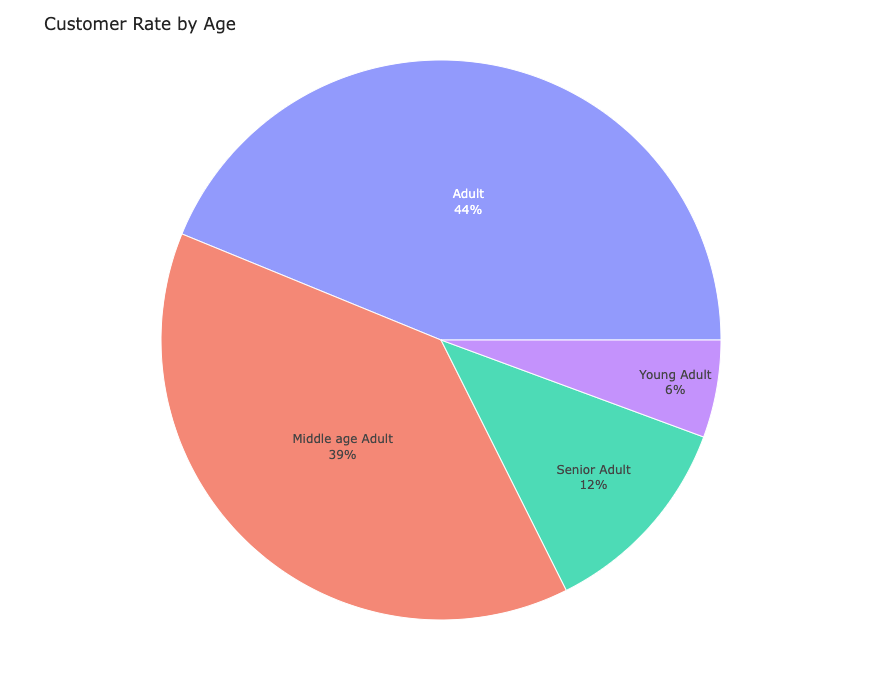

In [58]:
fig = px.sunburst(
    count_application_by_age,
    path=['age'], 
    color_discrete_sequence=px.colors.qualitative.Plotly,
)

fig.update_layout(
    title_text='Customer Rate by Age', 
    height=700,
    template='simple_white')
fig.update_traces(textinfo='label+percent parent')
fig.show()

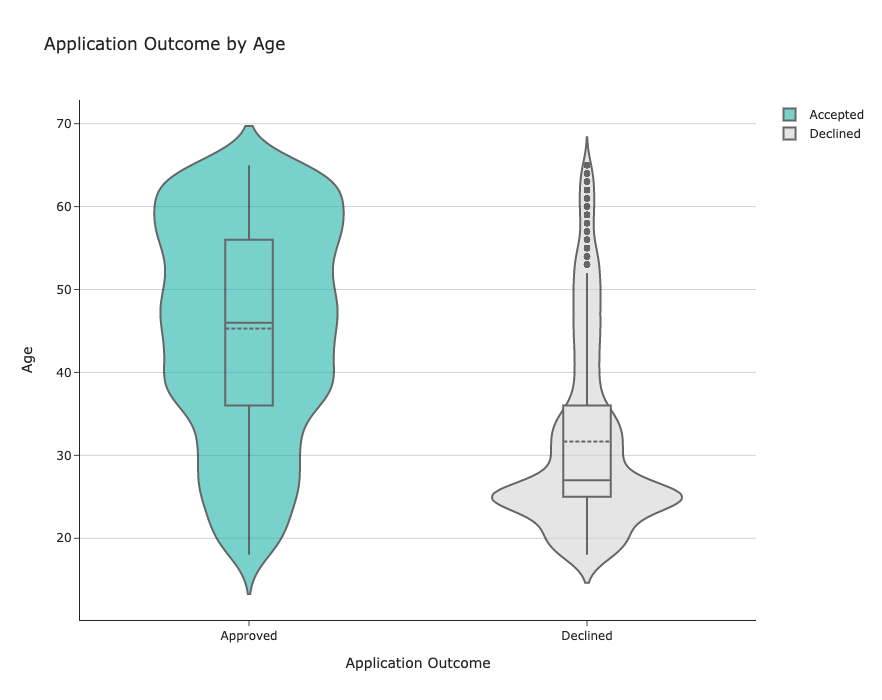

In [59]:
fig = go.Figure()

fig.add_trace(
    go.Violin(
        x = dataset[dataset['application_outcome'] == 'Approved']['application_outcome'],
        y = dataset['age'][dataset['application_outcome'] == 'Approved'],
        name='Accepted', 
        line_color='black', 
        meanline_visible=True, 
        fillcolor='lightseagreen', 
        opacity=0.6, 
        box_visible=True
    )
)

fig.add_trace(
    go.Violin(
        x = dataset[dataset['application_outcome'] == 'Declined']['application_outcome'],
        y = dataset['age'][dataset['application_outcome'] == 'Declined'],
        name='Declined',  
        line_color='black', 
        meanline_visible=True, 
        fillcolor='lightgrey', 
        opacity=0.6,
        box_visible=True
    )
)

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Lightgrey')
fig.update_layout(
    title_text='Application Outcome by Age', 
    xaxis_title='Application Outcome', 
    yaxis_title='Age', 
    height=700,
    template='simple_white')

fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0.2, violinmode='overlay')


### Clustering

In [60]:
data = copy.deepcopy(dataset)

In [61]:
data_1 = copy.deepcopy(dataset)
data_1['application_outcome'] = np.where(data['application_outcome']=='Approved', 1, 0)

In [62]:
df_clust = data.drop(['funded', 'apr', 'deposit', 'application_outcome'], axis=1)

In [63]:
# Convert all categorical features into dummies
df_clust = pd.get_dummies(df_clust, columns=['area', 'car_type'])
df_clust.head()

age  loan_amount  area_Rural  area_Urban  car_type_Convertible  \
id                                                                     
9997   61      24108.0           1           0                     1   
9996   42       5988.0           1           0                     0   
9995   57       5099.0           0           1                     0   
9994   32      20774.0           1           0                     1   
9993   29       4612.0           0           1                     0   

      car_type_SUV  car_type_Saloon  
id                                   
9997             0                0  
9996             0                1  
9995             0                1  
9994             0                0  
9993             0                1

In [64]:
# Standardize dataset's values so they follow a normal distribution
Min_list = []
Max_list = []

for features in ['loan_amount', 'age']:
    Min = df_clust[features].min()
    Max = df_clust[features].max()
    Min_list.append(Min)
    Max_list.append(Max)
    df_clust[features] = (df_clust[features] - Min)/(Max - Min)

In [65]:
df_clust.corr()

age  loan_amount  area_Rural  area_Urban  \
age                   1.000000     0.065728   -0.073383    0.073383   
loan_amount           0.065728     1.000000   -0.052637    0.052637   
area_Rural           -0.073383    -0.052637    1.000000   -1.000000   
area_Urban            0.073383     0.052637   -1.000000    1.000000   
car_type_Convertible  0.069691     0.589878   -0.036312    0.036312   
car_type_SUV         -0.104009    -0.157503    0.083711   -0.083711   
car_type_Saloon       0.039927    -0.419421   -0.051732    0.051732   

                      car_type_Convertible  car_type_SUV  car_type_Saloon  
age                               0.069691     -0.104009         0.039927  
loan_amount                       0.589878     -0.157503        -0.419421  
area_Rural                       -0.036312      0.083711        -0.051732  
area_Urban                        0.036312     -0.083711         0.051732  
car_type_Convertible              1.000000     -0.519920        -0.446042  
car_type_SUV                     -0.519920      1.000000        -0.532627  
car_type_Saloon                  -0.446042     -0.532627         1.000000

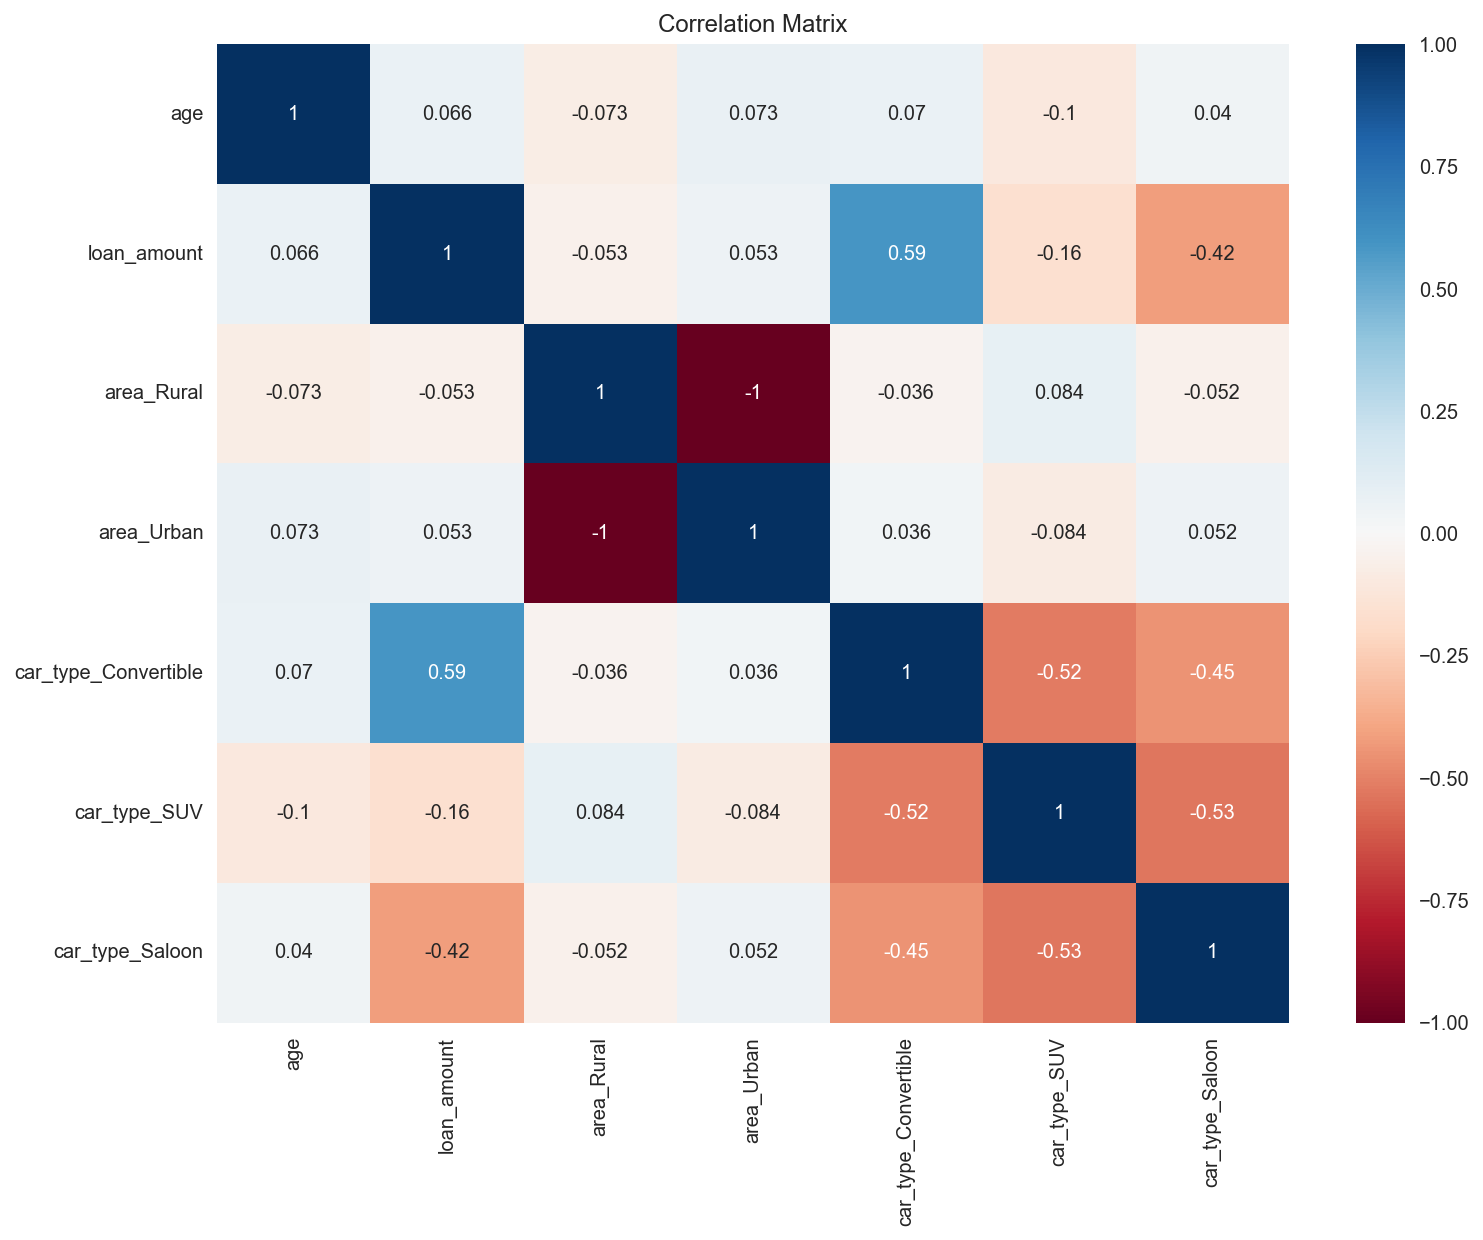

In [66]:
plt.figure(figsize=(12, 9))
cor_matr = sns.heatmap(
    df_clust.corr(),
    annot=True,
    cmap='RdBu',
    vmin=-1,
    vmax=1)
cor_matr.set_xticklabels(cor_matr.get_xticklabels(), rotation=90)
plt.title('Correlation Matrix')
plt.show()

In [67]:
ssd = {}

for i in range (1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_clust)
    ssd[i] = kmeans.inertia_

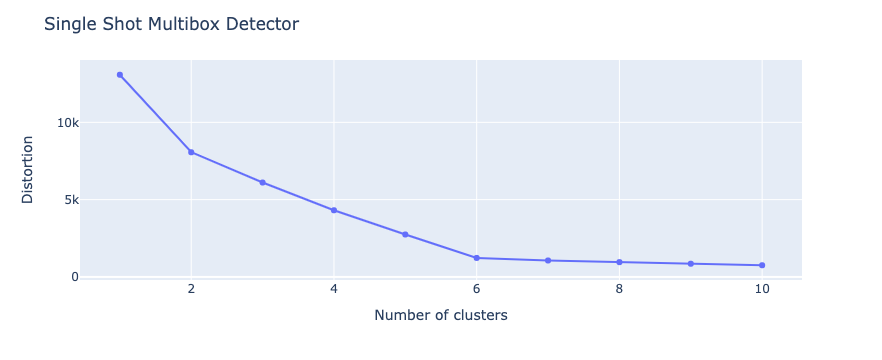

In [68]:
fig = px.line(
    x=ssd.keys(),
    y=ssd.values(), 
    markers=True
)

fig.update_layout(
    title_text='Single Shot Multibox Detector', 
    xaxis_title='Number of clusters', 
    yaxis_title='Distortion'
)

fig.show()

What we're looking for is the inflection point. In this case, it seems that 6 might be a good one. I will check with the silhouette score.

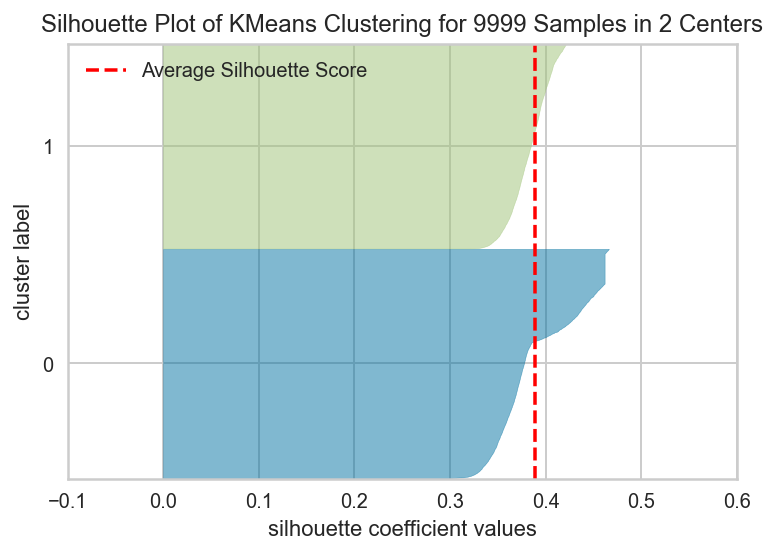

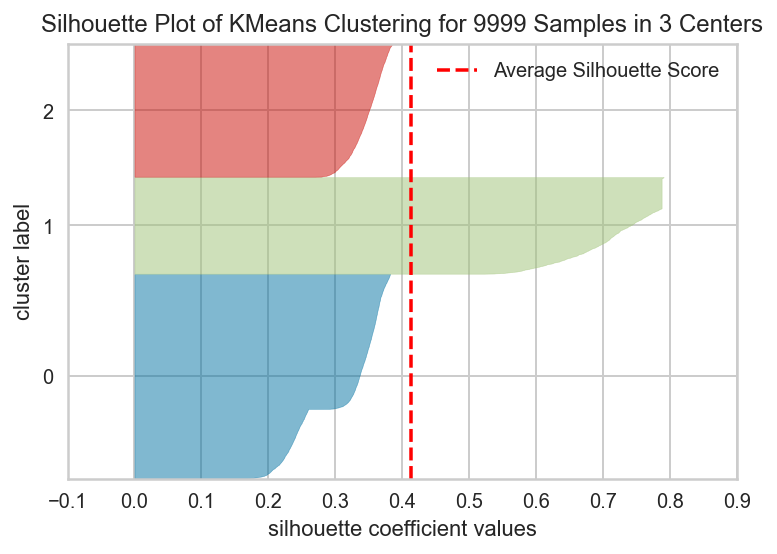

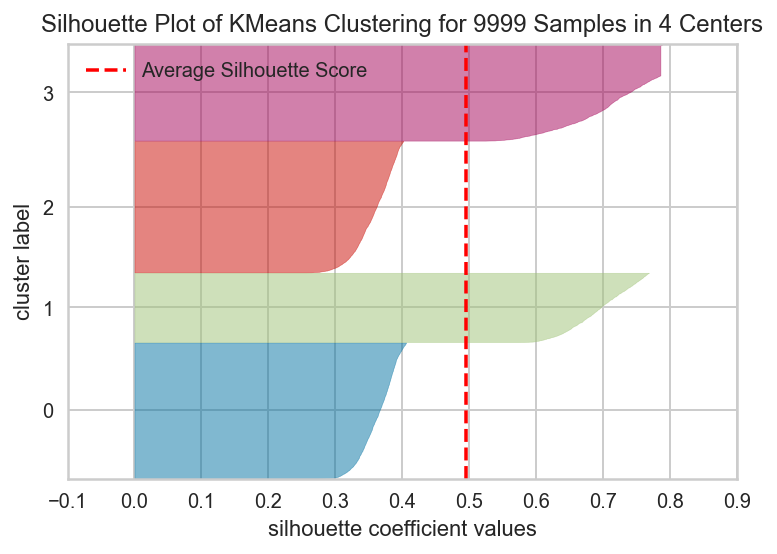

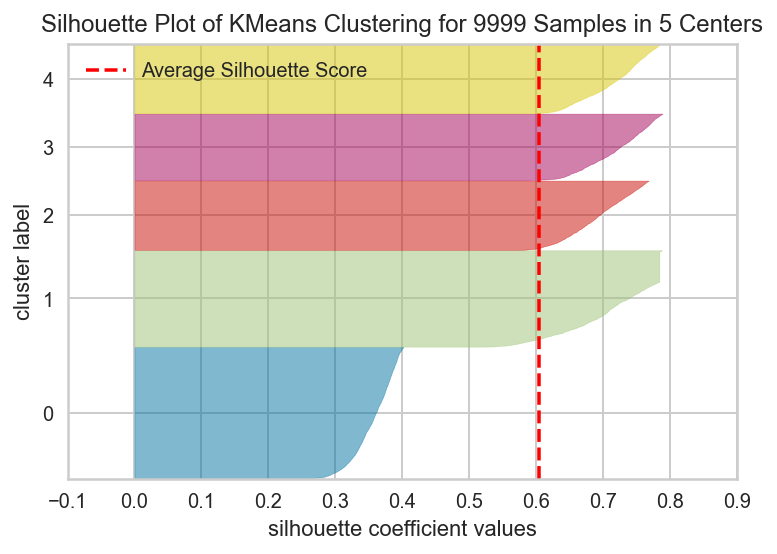

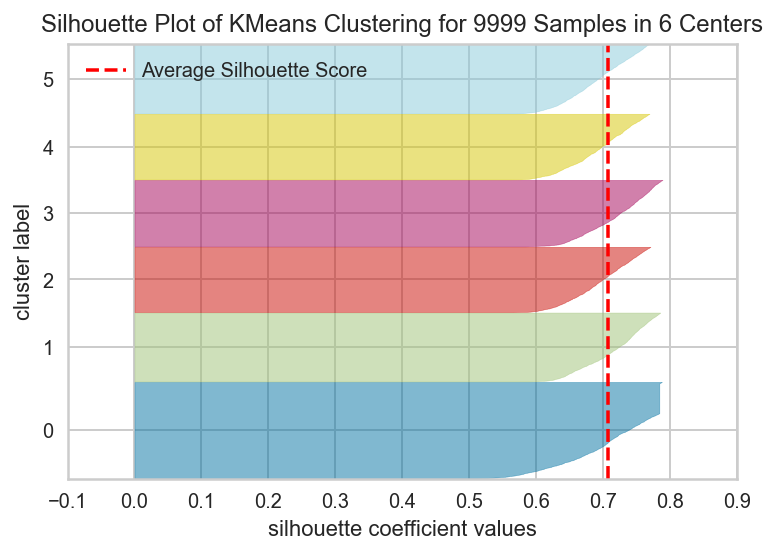

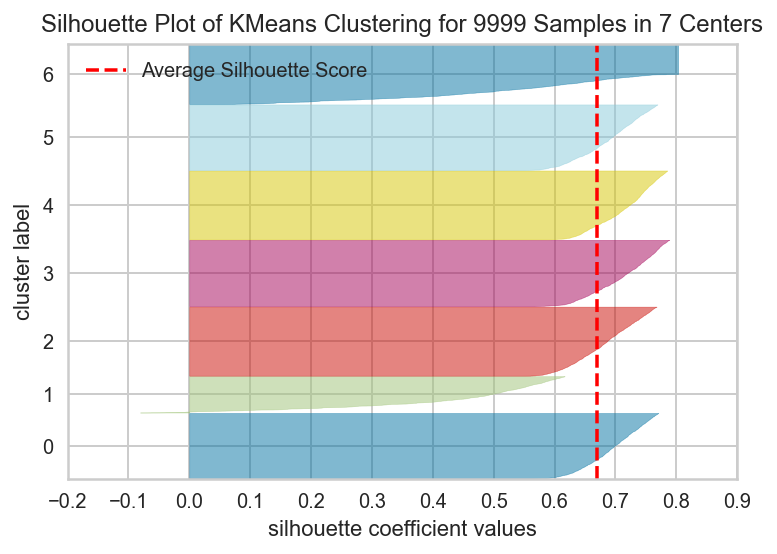

In [69]:
for i in [2,3,4,5,6,7]:
    kmeans = KMeans(n_clusters=i, random_state=42)
    visualizer = silhouette_visualizer(kmeans, df_clust, colors='yellowbrick')
    visualizer.show()

In [70]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit(df_clust)

KMeans(n_clusters=6, random_state=42)

In [71]:
# A higher silhouette score is indicative of a better model
print(round(silhouette_score(df_clust, kmeans.labels_, metric='euclidean'), 4))

0.7065


In [72]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(df_clust)

In [73]:
# Add cluster column to dataset
df_clust['Cluster'] = clusters
data_1['Cluster'] = clusters

In [74]:
# All clusters are well balanced in term of number of entries
data_1['Cluster'].value_counts()

0    2229
5    1601
1    1597
3    1539
4    1521
2    1512
Name: Cluster, dtype: int64

In [75]:
# The acceptance rate for each cluster 
data_1.groupby('Cluster').mean()['application_outcome']

Cluster
0    0.471961
1    0.711960
2    0.738095
3    0.642625
4    0.658120
5    0.733292
Name: application_outcome, dtype: float64

In [76]:
df_clust.groupby('Cluster').mean()

age  loan_amount  area_Rural  area_Urban  car_type_Convertible  \
Cluster                                                                        
0        0.399874     0.321125         1.0         0.0                   0.0   
1        0.501272     0.242420         0.0         1.0                   0.0   
2        0.510343     0.604651         0.0         1.0                   1.0   
3        0.490329     0.228515         1.0         0.0                   0.0   
4        0.509225     0.594321         1.0         0.0                   1.0   
5        0.493309     0.358261         0.0         1.0                   0.0   

         car_type_SUV  car_type_Saloon  
Cluster                                 
0                 1.0              0.0  
1                 0.0              1.0  
2                 0.0              0.0  
3                 0.0              1.0  
4                 0.0              0.0  
5                 1.0              0.0

In [77]:
data_1.groupby('Cluster').mean()

age   loan_amount      deposit       apr  application_outcome
Cluster                                                                     
0        36.794078  10364.414087  2254.997757  0.150691             0.471961
1        41.559800   8437.400125  2445.387602  0.149674             0.711960
2        41.986111  17306.267857  3145.738757  0.147989             0.738095
3        41.045484   8096.951917  2345.269006  0.149311             0.642625
4        41.933596  17053.358974  3072.838922  0.148297             0.658120
5        41.185509  11273.665834  2939.923173  0.150431             0.733292

In [78]:
# Focus on the best cluster
first_best = data_1[data_1['Cluster']==2].copy()
first_best['application_outcome'] = np.where(first_best['application_outcome']== 1, 'Accepted', 'Declined')
first_best['funded'] = np.where(first_best['funded']== 'Yes', 'Funded', 'Not Funded')

In [79]:
df = pd.crosstab(index=first_best['application_outcome'], columns = first_best['funded'])
df['Total'] = first_best['application_outcome'].value_counts()
df['Funded (%)'] = round(df['Funded']/df['Total']*100, 2)
df['Not Funded (%)'] = round(df['Not Funded']/df['Total']*100, 2)
df

funded               Funded  Not Funded  Total  Funded (%)  Not Funded (%)
application_outcome                                                       
Accepted                595         521   1116       53.32           46.68
Declined                  0         396    396        0.00          100.00

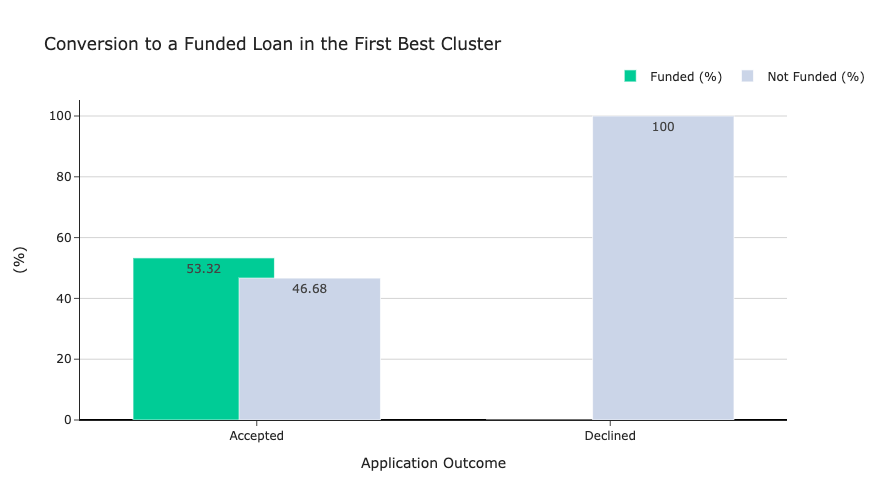

In [80]:
#Visualisation
fig = px.bar(
    df,
    x=df.index,
    y=['Funded (%)', 'Not Funded (%)'], 
    title='Conversion to a Funded Loan in the First Best Cluster',
    width=800, 
    height=500, 
    text_auto=True, 
    color_discrete_map={# replaces default color mapping by value
    'Not Funded (%)': 'rgb(203, 213, 232)', 'Funded (%)': '#00CC96'},
    labels={# replaces default labels by column name
        'value': '(%)', 'application_outcome': 'Application Outcome'},
    template='simple_white'
)

fig.update_layout(
    legend=dict(orientation='h', yanchor='bottom', y=1.03, x=0.75), 
    legend_title_text=None
)

fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_traces(width=0.4)
fig.update_layout(barmode='group', bargap=0.40, bargroupgap=0.3)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Lightgrey')
fig.show()

In [81]:
car_preference = first_best['car_type'].value_counts()
car_preference

Convertible    1512
Name: car_type, dtype: int64

In [82]:
second_best = data_1[data_1['Cluster'] == 5].copy()

second_best['application_outcome'] = np.where(
    second_best['application_outcome']== 1, 'Accepted', 'Declined')

second_best['funded'] = np.where(second_best['funded']== 'Yes', 'Funded', 'Not Funded')

In [83]:
df_2 = pd.crosstab(index=second_best['application_outcome'], columns = second_best['funded'])
df_2['Total'] = second_best['application_outcome'].value_counts()
df_2['Funded (%)'] = round(df_2['Funded']/df_2['Total']*100, 3)
df_2['Not Funded (%)'] = round(df_2['Not Funded']/df_2['Total']*100, 3)
df_2

funded               Funded  Not Funded  Total  Funded (%)  Not Funded (%)
application_outcome                                                       
Accepted                622         552   1174      52.981          47.019
Declined                  0         427    427       0.000         100.000

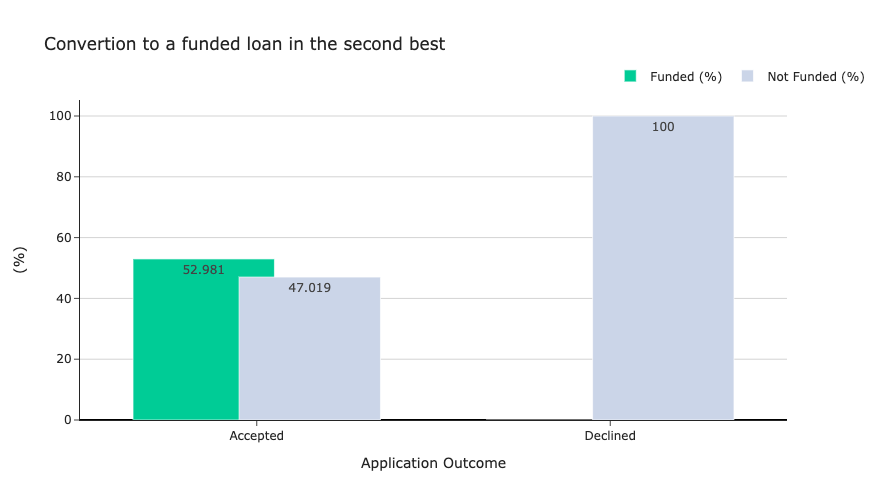

In [84]:
#Visualisation
fig = px.bar(
    df_2,
    x=df_2.index,
    y=['Funded (%)', 'Not Funded (%)'], 
    title='Convertion to a funded loan in the second best',
    width=800, 
    height=500, 
    text_auto=True, 
    color_discrete_map={# replaces default color mapping by value
    'Not Funded (%)': 'rgb(203, 213, 232)', 'Funded (%)': '#00CC96'},
    labels={# replaces default labels by column name
        'value': '(%)', 'application_outcome': 'Application Outcome'},
    template='simple_white'
)

fig.update_layout(
    legend=dict(orientation='h', yanchor='bottom', y=1.03, x=0.75), 
    legend_title_text=None
)

fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_traces(width=0.4)
fig.update_layout(barmode='group', bargap=0.40, bargroupgap=0.3)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Lightgrey')
fig.show()